# EKE generation correlation plots and cumulative integrals

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

from collections import OrderedDict
from matplotlib import gridspec


In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46751 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 44.92 GiB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

### Load parameters

In [4]:
expt = '01deg_jra55v13_ryf9091'
# reference density value:
rho_0 = 1035.0
g = 9.81

In [5]:
## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)


In [6]:
%%time

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)


CPU times: user 3.11 s, sys: 611 ms, total: 3.72 s
Wall time: 22.1 s


In [7]:
%%time

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)

CPU times: user 1.3 s, sys: 416 ms, total: 1.72 s
Wall time: 15.9 s


### Load energy terms

In [8]:
path = '/g/data/x77/cy8964/Post_Process/New_SO/Paper_Data/'

In [12]:
EKE = xr.open_dataset(path+'EKE_10yr.nc').EKE
EKE_budget_1 = xr.open_dataset(path+'EKE_budget_advective_term_1_10yr.nc').EKE_budget_1
EKE_budget_2 = xr.open_dataset(path+'EKE_budget_advective_term_2_10yr.nc').EKE_budget_2
EKE_budget_3 = xr.open_dataset(path+'EKE_budget_baroclinic_gen_term_10yr.nc').EKE_budget_3
#Reynolds = xr.open_dataset(path+'Reynolds_10yr.nc').Reynolds
Reynolds = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/Reynolds_10yr_fulldepth.nc').Reynolds

Form_stress = xr.open_dataset(path+'Form_stress_10yr.nc').Form_stress

In [13]:
SSH = xr.open_dataset(path+'ssh_avg_10yr.nc').ssh_avg

Plot cumsum of energy terms between SSH=-0.6 and SSH=-1.5

0
1
-0.0001287087430467447
2
0.0003846548736295592
3
1.2614103589412622
4
0.1684168782557943
5
0.0027939631133337447


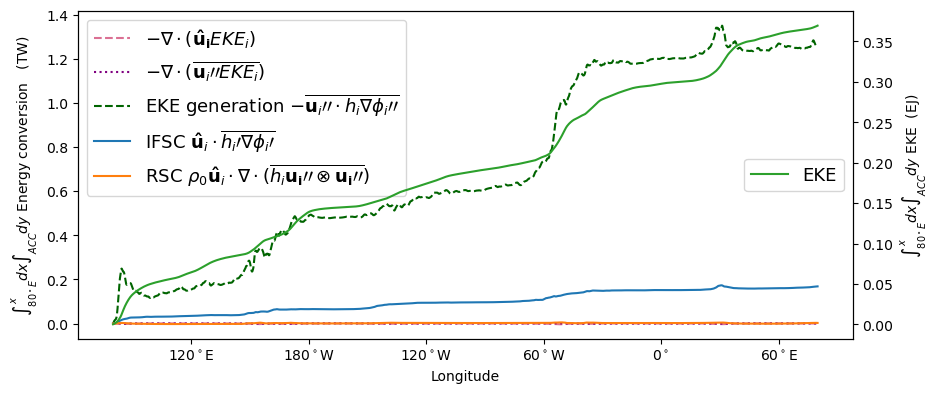

In [29]:
fig = plt.figure(figsize = (10,4.5))
ax = fig.add_subplot()
ax2 = ax.twinx()
for i in np.arange(6):
    salt = [EKE,-EKE_budget_1,-EKE_budget_2,-EKE_budget_3,Form_stress,Reynolds ][i]
    label = ['EKE',r'$- \nabla \cdot (\mathbf{\hat{u}_i}EKE_i) $',
            r'$-\nabla \cdot (\overline{\mathbf{u }_i\prime \prime EKE_i})$',
            'EKE generation '+r'$-\overline{\mathbf{u}_i\prime \prime\cdot h_i\nabla \phi_i\prime \prime}$',
            #'MP mean flux '+r'$ -\nabla \cdot (\overline{\phi_i\prime h_i\prime} \mathbf{\hat{u}_i}) $',
            #'MP eddy flux  '+r'$-\nabla \cdot (\overline{\mathbf{u}_i\prime\prime h_i\phi_i\prime})$',
            #'EAPE generation '+r'$ \overline{\phi\prime \partial_t h_i\prime} $',             
            'IFSC '+r'$\mathbf{\hat{u}}_i \cdot \overline{h_i\prime\nabla\phi_i\prime}$',
            'RSC '+r'$\rho_0\mathbf{\hat{u}}_i\cdot\nabla\cdot(\overline{h_i\mathbf{u_i\prime\prime}\otimes\mathbf{u_i\prime \prime}})$',
            'Sum at MP junction'][i]
    print(i)
    color = ['C2','palevioletred','purple','darkgreen','C0','C1'][i]
    linestyle = ['-','--','dotted','--','-','-'][i]
    SSH_band_int_y_cumsum_x = (salt.where(SSH < -0.6).where(SSH > -1.5).sum('isopycnal_bins')*dyt*dxt).sum('yt_ocean').cumsum('xt_ocean')
    if i ==0:
         (SSH_band_int_y_cumsum_x/1e18).plot(ax = ax2, color = color, label = label, linestyle = linestyle)
    else:
        (SSH_band_int_y_cumsum_x/1e12).plot(ax = ax, color = color, label = label, linestyle = linestyle)
        print((SSH_band_int_y_cumsum_x[-1]/1e12).values)
ax.set_title('')
ax.legend(loc = 'upper left', fontsize = 13)
ax2.legend(loc = 'center right', fontsize = 13)
ax.set_ylabel('$\int_{80^\circ E}^xdx \int_{ACC}dy$ Energy conversion   (TW)')
ax2.set_ylabel('$\int_{80^\circ E}^xdx\int_{ACC}dy$ EKE  (EJ)')
#ax.hlines(0,-1,xt_ocean.values[-1]+1, color = 'grey',linestyle = '-',alpha = 0.5)
X = np.arange(-240,100,60)
ax.set_xticks(X)
ax.set_xticklabels(('120$^\circ$E','180$^\circ$W','120$^\circ$W','60$^\circ$W','0$^\circ$','60$^\circ$E'));
ax.set_xlabel('Longitude')
plt.subplots_adjust(bottom = 0.15)

#### Integrated over 35S-75S

In [16]:
a= ((-EKE_budget_1/1e12).sum('isopycnal_bins')*dxt*dyt).sum('xt_ocean').sum('yt_ocean')
print(a.values)
a= ((-EKE_budget_2/1e12).sum('isopycnal_bins')*dxt*dyt).sum('xt_ocean').sum('yt_ocean')
print(a.values)
a= ((-EKE_budget_3/1e12).sum('isopycnal_bins')*dxt*dyt).sum('xt_ocean').sum('yt_ocean')
print(a.values)
a= ((Form_stress/1e12).sum('isopycnal_bins')*dxt*dyt).sum('xt_ocean').sum('yt_ocean')
print(a.values)
a= ((Reynolds/1e12).sum('isopycnal_bins')*dxt*dyt).sum('xt_ocean').sum('yt_ocean')
print(a.values)

0.0008351491024901998
-0.00021298367335170418
0.15536720253537595
0.2888761343615477
0.02808390525110315


In [23]:
salt = Reynolds
SSH_band_int_y_cumsum_x=(salt.where(SSH > -0.7).sum('isopycnal_bins')*dyt*dxt).sum('yt_ocean').cumsum('xt_ocean')
print((SSH_band_int_y_cumsum_x[-1]/1e12).values)

0.028059728467506782


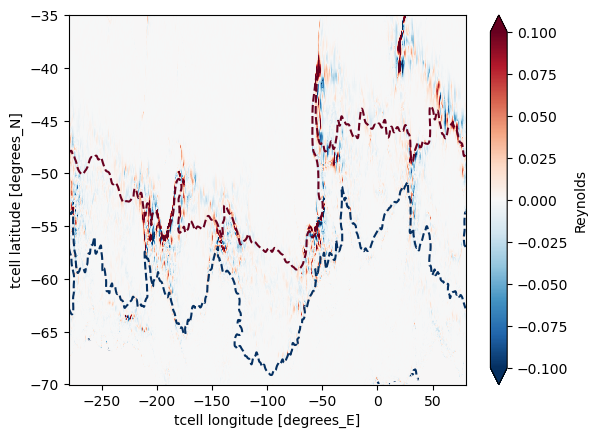

In [20]:
Reynolds.sum('isopycnal_bins').plot(vmax = 0.1)
SSH.plot.contour(levels = [-0.6,-1.5])

A lot of the Reynolds stress conversion occurs north of the ACC.

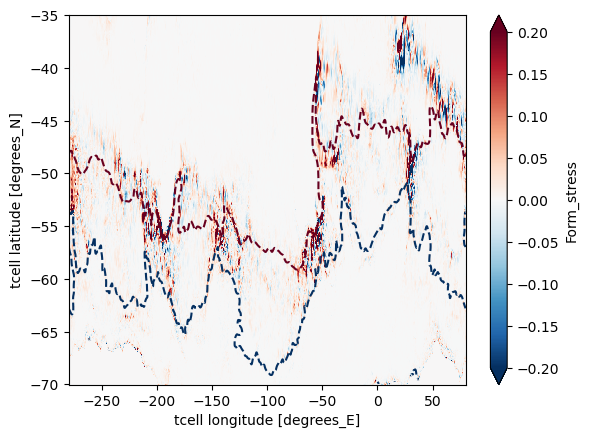

In [21]:
Form_stress.sum('isopycnal_bins').plot(vmax = 0.2)
SSH.plot.contour(levels = [-0.6,-1.5])

#### Find local magnitudes (average magnitude integrated over the whole region)

In [28]:
for i in np.arange(4):
    salt = [EKE,-EKE_budget_1-EKE_budget_2,-EKE_budget_3,Form_stress,Reynolds, ][i]
    label = ['EKE',r'$- \nabla \cdot (\mathbf{\hat{u}_i}EKE_i) $',
            'EKE generation '+r'$-\overline{\mathbf{u}_i\prime \prime\cdot h_i\nabla \phi_i\prime \prime}$',
            #'MP mean flux '+r'$ -\nabla \cdot (\overline{\phi_i\prime h_i\prime} \mathbf{\hat{u}_i}) $',
            #'MP eddy flux  '+r'$-\nabla \cdot (\overline{\mathbf{u}_i\prime\prime h_i\phi_i\prime})$',
            #'EAPE generation '+r'$ \overline{\phi\prime \partial_t h_i\prime} $',             
            'IFSC '+r'$\mathbf{\hat{u}}_i \cdot \overline{h_i\prime\nabla\phi_i\prime}$',
            'RSC '+r'$\rho_0\mathbf{\hat{u}}_i\cdot\nabla\cdot(\overline{h_i\mathbf{u_i\prime\prime}\otimes\mathbf{u_i\prime \prime}})$',
            'Sum at MP junction'][i]
    print(i)
    color = ['C2','palevioletred','purple','darkgreen','C0','C1'][i]
    linestyle = ['-','--','dotted','--','-','-'][i]
    SSH_band_int_y_cumsum_x = (np.abs(salt).where(SSH < -0.6).where(SSH > -1.5).sum('isopycnal_bins')*dyt*dxt).sum('yt_ocean').cumsum('xt_ocean')
    if i ==0:
        print('hi')
    else:
        print((SSH_band_int_y_cumsum_x[-1]/1e12).values)

0
hi
1
0.1865276794956107
2
10.151059527103262
3
1.3690369668737863


# The following is to compare EKE and the energy terms for lags, in the same way that EKE was compared with transport.


In [25]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

### correlation with EKE

In [22]:
from correlation1 import Compute_Correlation

In [30]:

def plot_cumsum_correlation(salt,j_contour):

    if contour_dict[j_contour]['shifted']==True:
        salt = salt.roll(xt_ocean = 800)
        salt.coords['xt_ocean']=np.linspace(0.05,359.95,3600)

    #inititalise empty array
    salt_along_contour = xr.DataArray(np.zeros((len(salt.isopycnal_bins),len(contour_index_array))),
                                      coords = [salt.isopycnal_bins, contour_index_array],
                                      dims = ['isopycnal_bins', 'contour_index'],
                                      name = 'salt_along_contour')

    salt_i = salt.rename({'yt_ocean':'y_ocean', 'xt_ocean':'x_ocean'}) 

    # Note that this interpolation does not work as generically as e.g. salt.interp(),
    #    but it is much faster and doesn't require removing chunking (which also slow things down).
    # Be careful that your latitude range extends at least one point either direction beyond your contour.
    # If your domain is not the full longitude range, you will need to adapt this, so you have the correct interpolation
    #    only the edges of your domain (it assumes it is reentrant).
    # Need to overwrite coords, so these two variables can be added together:
    salt_w = salt_i.copy()
    salt_w.coords['x_ocean'] = xu_ocean.values
    salt_e = salt_i.roll(x_ocean=-1)
    salt_e.coords['x_ocean'] = xu_ocean.values
    # salt_xgrid will be on the uhrho grid:
    salt_xgrid = (salt_e + salt_w)/2

    salt_s = salt_i.copy()
    salt_s.coords['y_ocean'] = yu_ocean.values
    salt_n = salt_i.roll(y_ocean=-1)
    salt_n.coords['y_ocean'] = yu_ocean.values
    # salt_ygrid will be on the vhrho grid:
    salt_ygrid = (salt_s + salt_n)/2

    # stack transports into 1d and drop any points not on contour:
    salt_xgrid = (salt_xgrid*dyt).where(mask_x_transport_numbered>0)
    salt_ygrid = (salt_ygrid*dxu).where(mask_y_transport_numbered>0)
    x_salt_1d = salt_xgrid.stack(contour_index = ['y_ocean', 'x_ocean'])
    y_salt_1d = salt_ygrid.stack(contour_index = ['y_ocean', 'x_ocean'])
    x_salt_1d = x_salt_1d.where(mask_x_numbered_1d>0,drop=True)
    y_salt_1d = y_salt_1d.where(mask_y_numbered_1d>0,drop=True)

    # combine all points on contour:
    salt_along_contour_i = xr.concat((x_salt_1d, y_salt_1d), dim = 'contour_index')
    salt_along_contour_i = salt_along_contour_i.sortby(contour_ordering)
    salt_along_contour_i.coords['contour_index'] = contour_index_array
    salt_along_contour_i = salt_along_contour_i.load()

    # write into larger array:
    salt_along_contour[:,:] = salt_along_contour_i
    Conversion = salt_along_contour.sum('isopycnal_bins')#.cumsum('contour_index')
    EKE_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_contour_energies.nc').Form_contour
    EKE_corr = EKE_contour.sum('isopycnal_bins')#.cumsum('contour_index')
    c_cor = Compute_Correlation(EKE_corr, Conversion)
    c_cor2 = Compute_Correlation(Conversion,EKE_corr)
    corr,sig,t,N = c_cor.cor_series()
    #print(max(t))
    #print(min(N), max(N))
    corr2,sig2,t2,N2 = c_cor2.cor_series()
    corr_combined = np.append(np.flip(corr2[1:]),corr)
    sig_combined = np.append(np.flip(sig2[1:]),sig)
    distance_h = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
    distance_small = distance_h[0:len(corr)]
    distance_combined = np.append(-np.flip(distance_small)[:-1],distance_small)

    N_middle = int((len(distance_combined)-1)/2)
    fig, axes = plt.subplots(nrows = 1, ncols = 2)
    axes[0].plot(distance_h,EKE_corr, color = 'k', label = 'eddy transport')
    axes[0].set_ylabel('Transport (m$^2$s$^{-1}$)')
    ax2 = axes[0].twinx()
    ax2.plot(distance_h, Conversion, color = 'C0')
    #axes[0,2*i+1].yaxis.tick_right()
    axes[1].plot(distance_combined[N_middle-100:N_middle+100],corr_combined[N_middle-100:N_middle+100],color = 'forestgreen',linewidth=1,label='Correlation')
    axes[1].plot(distance_combined[N_middle-100:N_middle+100],(corr_combined*sig_combined)[N_middle-100:N_middle+100],color='forestgreen',linewidth=5,alpha=0.5,label="Significant")
    print(distance_combined[np.abs(corr_combined).argmax()])
    print(np.abs(corr_combined).max())
    sig_corr_region_distance = distance_combined[N_middle-100:N_middle+100][np.isfinite(sig_combined)[N_middle-100:N_middle+100]]
    plt.show()
    return distance_combined[N_middle-100:N_middle+100][np.abs(corr_combined[N_middle-100:N_middle+100]).argmax()], np.abs(corr_combined[N_middle-200:N_middle+200]).max(), sig_corr_region_distance

S


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 37% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 41% CPU time recently (threshold: 10%)


0.9328827250976562
0.28420234144994


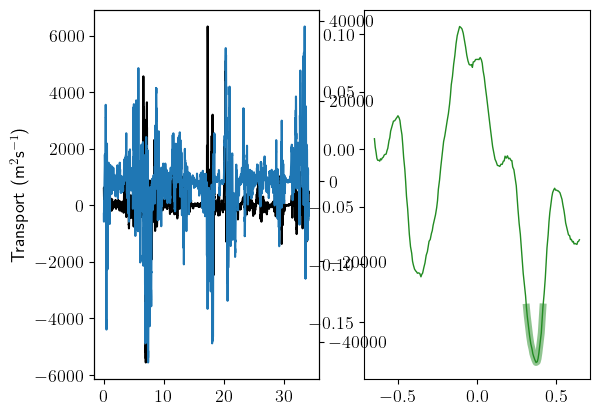

E


distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)


0.8895961298828126
0.21633009202895961


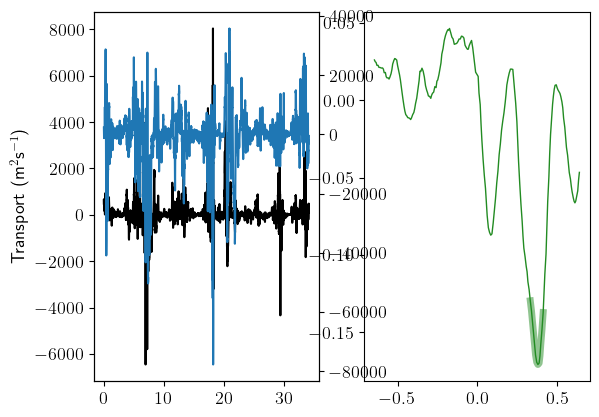

T


distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

0.38654708154296874
0.24079567004274563


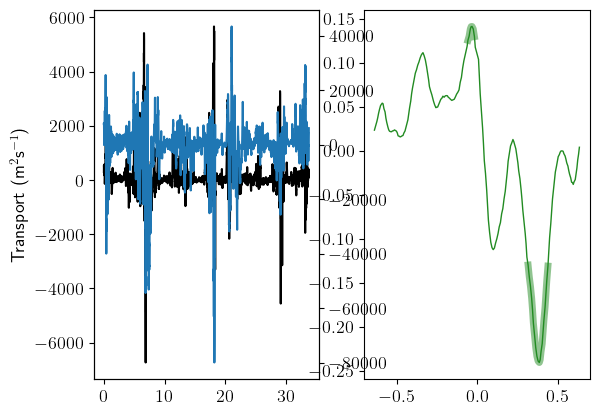

F


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


-0.3435389389648437
0.20896121866361386


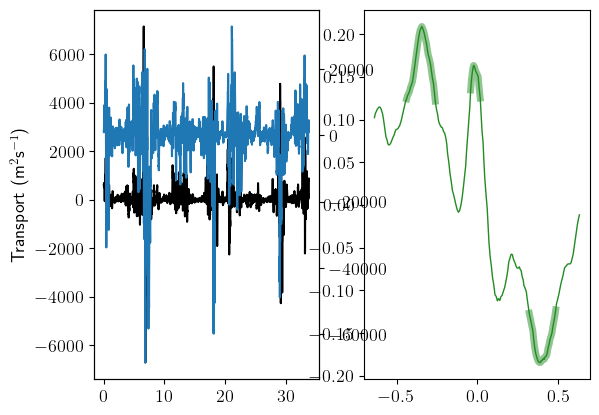

U


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


0.3856022607421875
0.18992291141923348


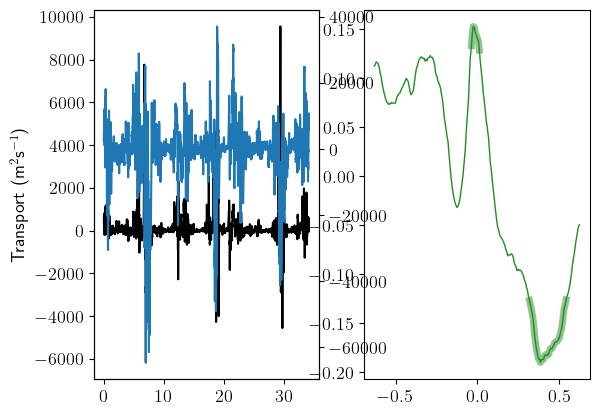

G


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


0.3509700659179687
0.17579539985784304


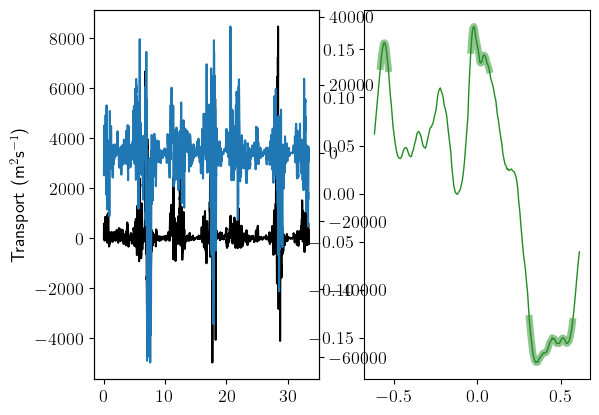

V


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


0.7118431923828125
0.19216201454483336


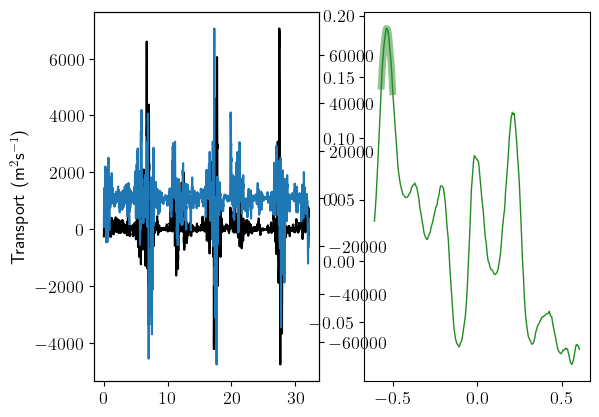

H


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 36% CPU time recently (threshold: 10%)


-7.732867582519531
0.30932533418081876


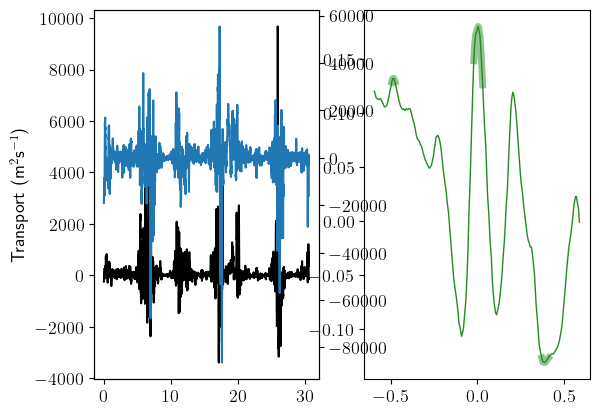

W


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)


-6.96962055859375
0.2065853674524649


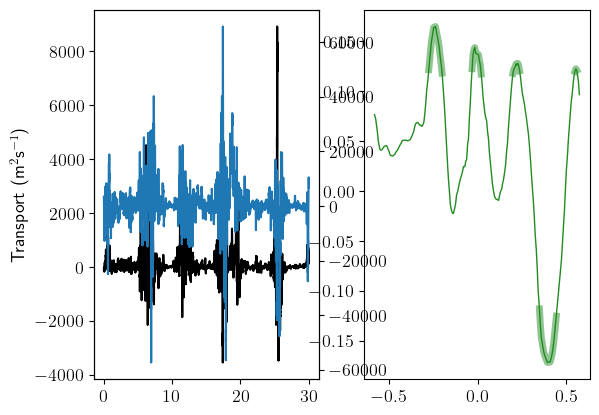

I


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


0.56919460546875
0.17588492777966036


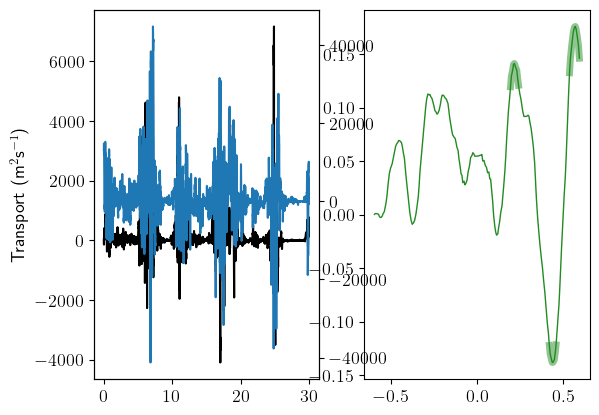

X


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


0.5610900209960937
0.18467303573890761


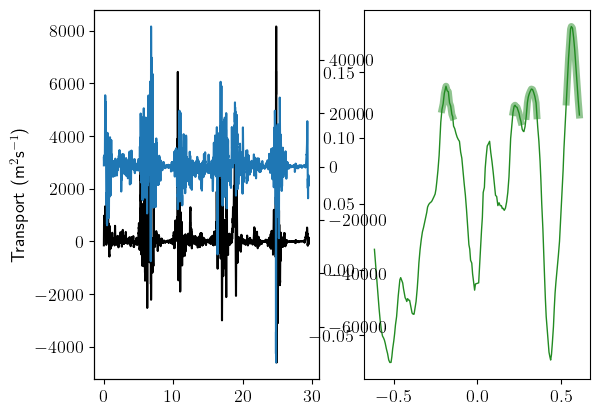

J


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)


0.29251927587890625
0.1929471138233814


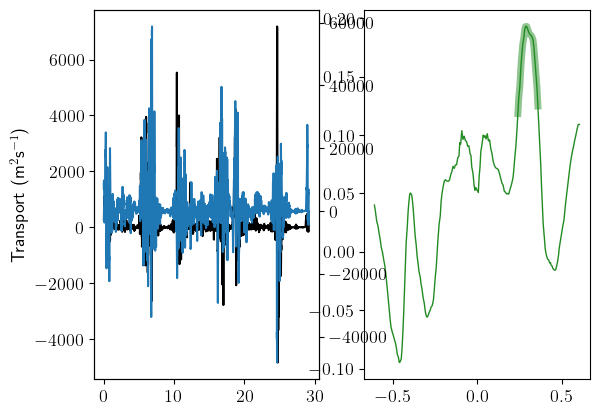

Y


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


0.302708595703125
0.23916478233774616


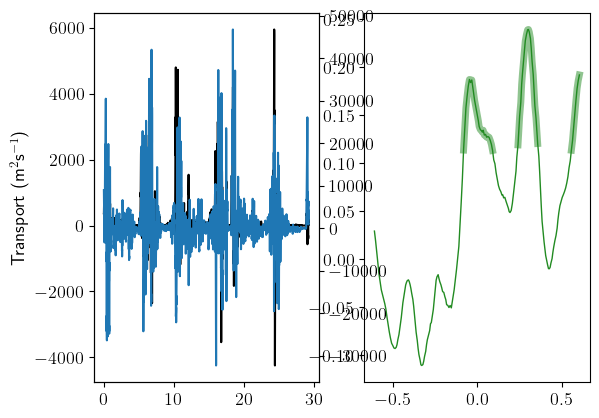

K


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)


0.26483500048828124
0.2781529429245104


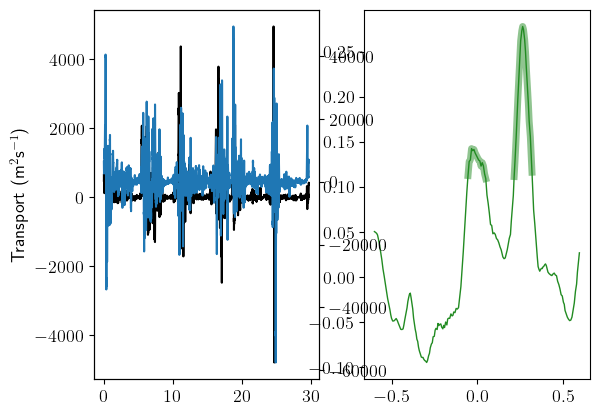

Z


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


-6.841351166992188
0.19492623860117603


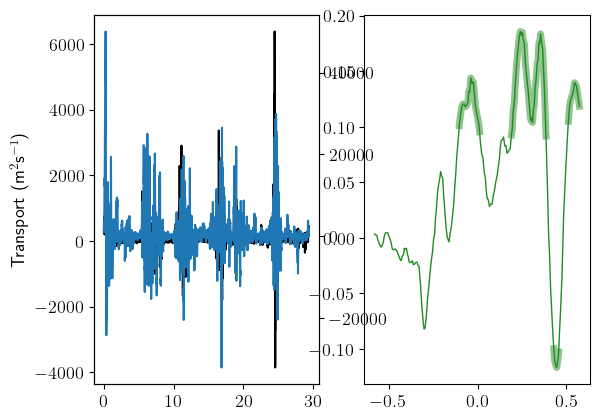

L


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)


0.46188257958984374
0.17097133848525828


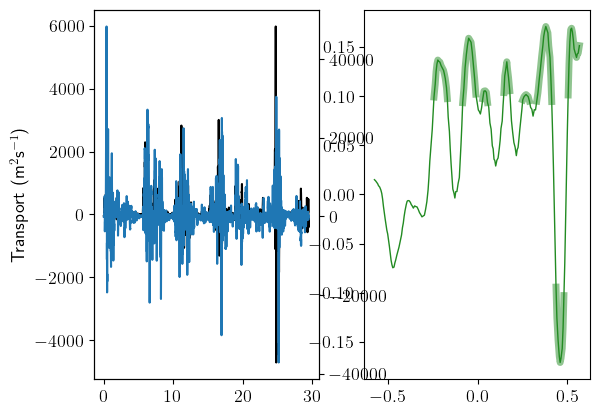

Z1


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 29% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

-0.02659215625
0.25134710843503766


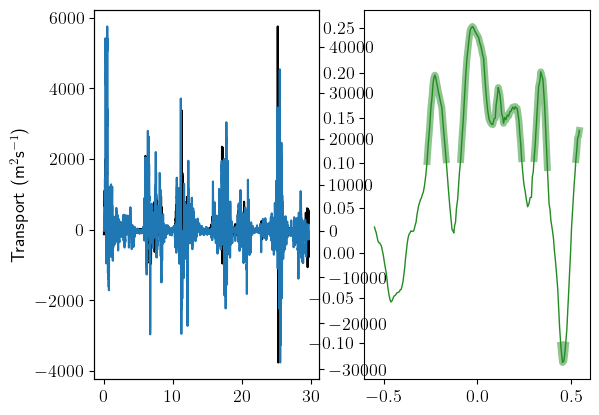

M


distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

0.022646929687499998
0.33715195252624386


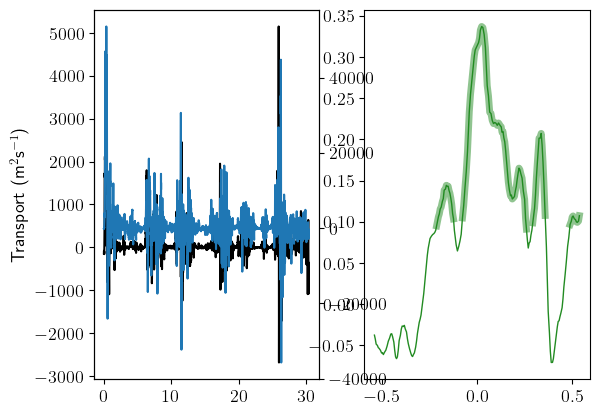

Z2


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

0.0358331298828125
0.3118643117201961


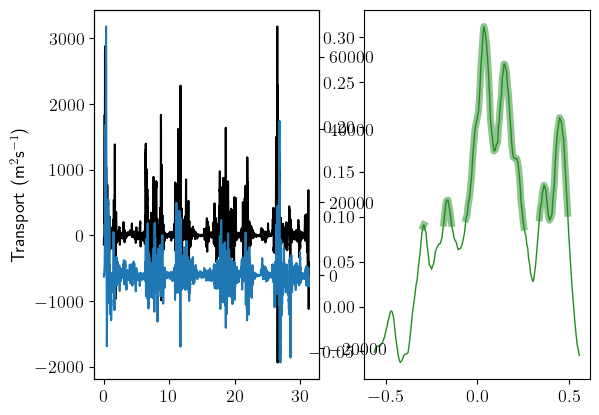

N


distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)


-EKE_budget_3


distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 35% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

-8.068232342285157
0.20097048444286972


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


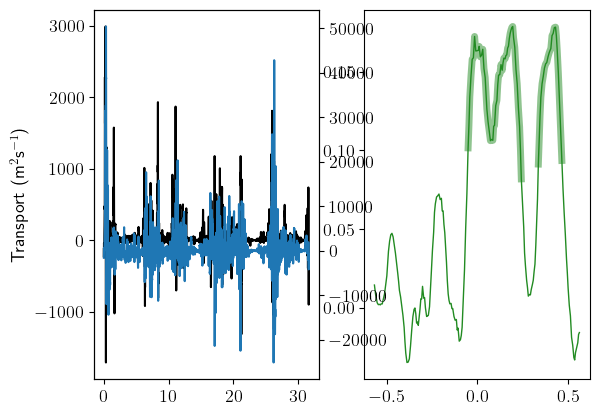

EKE_budget_1
mean
0.17644786205817656
stdev
0.2657323933488997
N
1030
stev/sqrtN
0.008279915158032001
EKE_budget_2
mean
nan
stdev
nan
N
0
stev/sqrtN
nan
EKE_gen
mean
nan
stdev
nan
N
0
stev/sqrtN
nan
FS
mean
nan
stdev
nan
N
0
stev/sqrtN
nan
RS
mean
nan
stdev
nan
N
0
stev/sqrtN
nan
MP_1
mean
nan
stdev
nan
N
0
stev/sqrtN
nan
MP2
mean
nan
stdev
nan
N
0
stev/sqrtN
nan


distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


In [31]:
corr = np.zeros((7,29))
dist = np.zeros((7,29))
EKE_downstream_0 = []
EKE_downstream_1 = []
EKE_downstream_2 = []
EKE_downstream_3 = []
EKE_downstream_4 = []
EKE_downstream_5 = []
EKE_downstream_6 = []

for j in np.arange(7,27):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
    print(j_contour)

    lat_range = contour_dict[j_contour]['lat_range']
    lat_range_big = contour_dict[j_contour]['lat_range_big']
    SSH = contour_dict[j_contour]['SSH']
    distance_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_distance_along_contour.nc').distance
    outfile = '/g/data/x77/cy8964/Post_Process/'+contour_dict[j_contour]['slope_path']
    data = np.load(outfile)
    mask_y_transport = data['mask_y_transport']
    mask_x_transport = data['mask_x_transport']
    mask_y_transport_numbered = data['mask_y_transport_numbered']
    mask_x_transport_numbered = data['mask_x_transport_numbered']

    if contour_dict[j_contour]['shifted']==True:
        yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
        yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
        yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
        yu_ocean = yu_ocean.sel(yu_ocean=lat_range)

        xt_ocean = cc.querying.getvar(expt, 'xt_ocean', session, n=1)
        xt_ocean = xt_ocean.roll(xt_ocean = 800)
        xt_ocean.coords['xt_ocean']=np.linspace(0.05,359.95,3600)
        xt_ocean = xt_ocean*0+xt_ocean.xt_ocean.values

        xu_ocean = cc.querying.getvar(expt, 'xu_ocean', session, n=1)
        xu_ocean = xu_ocean.roll(xu_ocean = 800)
        xu_ocean.coords['xu_ocean']=np.linspace(0.1,360,3600)
        xu_ocean = xu_ocean*0+xu_ocean.xu_ocean.values

        dyt = cc.querying.getvar(expt, 'dyt',session, n=1, ncfile = 'ocean_grid.nc')
        dyt = dyt.roll(xt_ocean = 800)
        dyt.coords['xt_ocean']=np.linspace(0.05,359.95,3600)

        dxu = cc.querying.getvar(expt, 'dxu',session, n=1, ncfile = 'ocean_grid.nc')
        dxu = dxu.roll(xu_ocean = 800)
        dxu.coords['xu_ocean']=np.linspace(0.1,360,3600)

        # select latitude range:
        dxu = dxu.sel(yu_ocean=lat_range)
        dyt = dyt.sel(yt_ocean=lat_range)

    elif contour_dict[j_contour]['shifted']==False:
        yt_ocean = cc.querying.getvar(expt, 'yt_ocean', session, n=1)
        yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
        yu_ocean = cc.querying.getvar(expt, 'yu_ocean', session, n=1)
        yu_ocean = yu_ocean.sel(yu_ocean=lat_range)

        xt_ocean = cc.querying.getvar(expt, 'xt_ocean', session, n=1)
        xu_ocean = cc.querying.getvar(expt, 'xu_ocean', session, n=1)

        dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
        dyt = dyt.sel(yt_ocean = lat_range)
        dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
        dxt = dxt.sel(yt_ocean = lat_range)

        dxu = cc.querying.getvar(expt,'dxu',session,ncfile = 'ocean_grid.nc',n=1)
        dxu = dxu.sel(yu_ocean = lat_range)

    dyt = dyt.reset_coords().dyt # remove geolon_t/geolat_t coordinates
    dxu = dxu.reset_coords().dxu # remove geolon_t/geolat_t coordinates
    dxu.coords['xu_ocean'] = xt_ocean.values
    dxu = dxu.rename({'yu_ocean':'y_ocean', 'xu_ocean':'x_ocean'}) 
    dyt.coords['xt_ocean'] = xu_ocean.values
    dyt = dyt.rename({'yt_ocean':'y_ocean','xt_ocean':'x_ocean'})

    # Convert contour masks to data arrays, so we can multiply them later.
    # We need to ensure the lat lon coordinates correspond to the actual data location:
    #       The y masks are used for vhrho, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
    #       The x masks are used for uhrho, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
    #       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
    #       to make concatenation of transports in both direction and sorting possible.

    mask_x_transport = xr.DataArray(mask_x_transport, coords = [('y_ocean', yt_ocean), ('x_ocean', xu_ocean)])
    mask_y_transport = xr.DataArray(mask_y_transport, coords = [('y_ocean', yu_ocean), ('x_ocean', xt_ocean)])
    mask_x_transport_numbered = xr.DataArray(mask_x_transport_numbered, coords = [('y_ocean', yt_ocean), ('x_ocean', xu_ocean)])
    mask_y_transport_numbered = xr.DataArray(mask_y_transport_numbered, coords = [('y_ocean', yu_ocean), ('x_ocean', xt_ocean)])

    mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
    mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)
    mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
    mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)
    contour_ordering = xr.concat((mask_x_numbered_1d,mask_y_numbered_1d), dim = 'contour_index')
    contour_ordering = contour_ordering.sortby(contour_ordering)
    contour_index_array = np.arange(1,len(contour_ordering)+1)
    
    
    for i in np.arange(1):
        salt = [-EKE_budget_3,-EKE_budget_2,-EKE_budget_3,Form_stress,Reynolds,-MP_flux_1,-MP_flux_2][i]
        name = ['-EKE_budget_3','-EKE_budget_2','-EKE_budget_3','Form_stress','Reynolds','-MP_flux_1','-MP_flux_2'][i]
        print(name)
        a,b, c = plot_cumsum_correlation(salt.sel(yt_ocean=lat_range),j_contour)
        corr[i,j] = b
        dist[i,j]= a
        if i ==0:
            EKE_downstream_0 = np.append(EKE_downstream_0, c)
        if i ==1:
            EKE_downstream_1 = np.append(EKE_downstream_1, c)
        if i ==2:
            EKE_downstream_2 = np.append(EKE_downstream_2, c)
        if i ==3:
            EKE_downstream_3 = np.append(EKE_downstream_3, c)
        if i ==4:
            EKE_downstream_4 = np.append(EKE_downstream_4, c)
        if i ==5:
            EKE_downstream_5 = np.append(EKE_downstream_5, c)
        if i ==6:
            EKE_downstream_6 = np.append(EKE_downstream_6, c)

            
print('EKE_budget_1')            
print('mean')
print(np.mean(EKE_downstream_0))
print('stdev')
print(np.std(EKE_downstream_0))
print('N')
print(len(EKE_downstream_0))
print('stev/sqrtN')
print(np.std(EKE_downstream_0)/np.sqrt(len(EKE_downstream_0)))      

print('EKE_budget_2')            
print('mean')
print(np.mean(EKE_downstream_1))
print('stdev')
print(np.std(EKE_downstream_1))
print('N')
print(len(EKE_downstream_1))
print('stev/sqrtN')
print(np.std(EKE_downstream_1)/np.sqrt(len(EKE_downstream_1)))    

print('EKE_gen')            
print('mean')
print(np.mean(EKE_downstream_2))
print('stdev')
print(np.std(EKE_downstream_2))
print('N')
print(len(EKE_downstream_2))
print('stev/sqrtN')
print(np.std(EKE_downstream_2)/np.sqrt(len(EKE_downstream_2)))    

print('FS')            
print('mean')
print(np.mean(EKE_downstream_3))
print('stdev')
print(np.std(EKE_downstream_3))
print('N')
print(len(EKE_downstream_3))
print('stev/sqrtN')
print(np.std(EKE_downstream_3)/np.sqrt(len(EKE_downstream_3)))      

print('RS')            
print('mean')
print(np.mean(EKE_downstream_4))
print('stdev')
print(np.std(EKE_downstream_4))
print('N')
print(len(EKE_downstream_4))
print('stev/sqrtN')
print(np.std(EKE_downstream_4)/np.sqrt(len(EKE_downstream_4)))   

print('MP_1')            
print('mean')
print(np.mean(EKE_downstream_5))
print('stdev')
print(np.std(EKE_downstream_5))
print('N')
print(len(EKE_downstream_5))
print('stev/sqrtN')
print(np.std(EKE_downstream_5)/np.sqrt(len(EKE_downstream_5)))      

print('MP2')            
print('mean')
print(np.mean(EKE_downstream_6))
print('stdev')
print(np.std(EKE_downstream_6))
print('N')
print(len(EKE_downstream_6))
print('stev/sqrtN')
print(np.std(EKE_downstream_6)/np.sqrt(len(EKE_downstream_6)))      


### Plot histogram of downstream distance

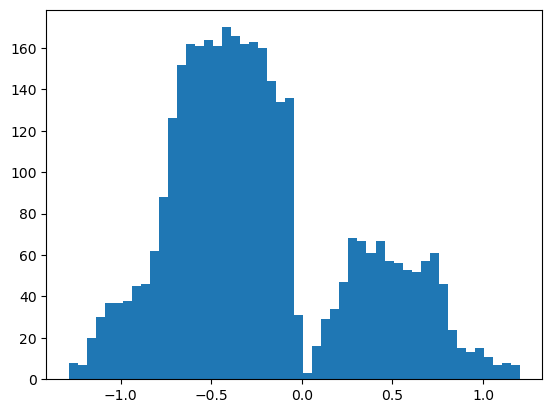

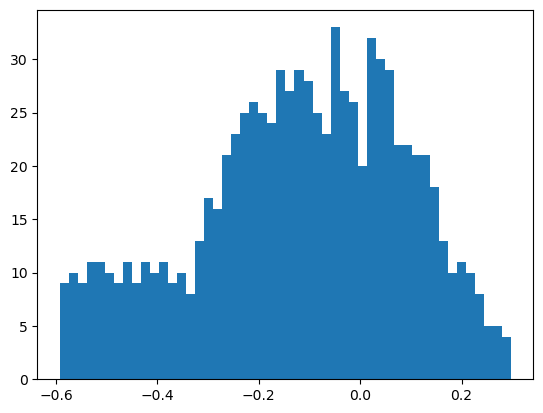

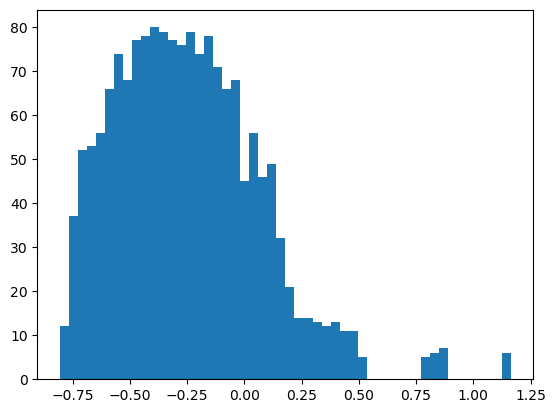

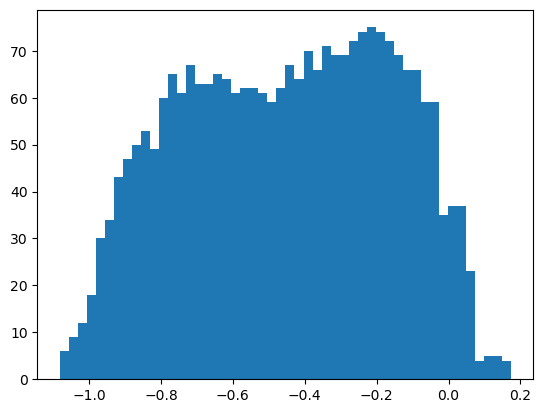

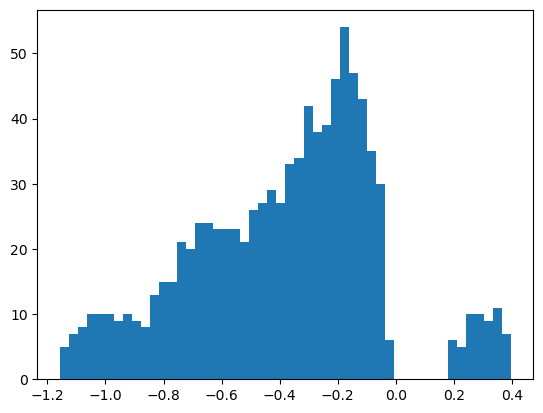

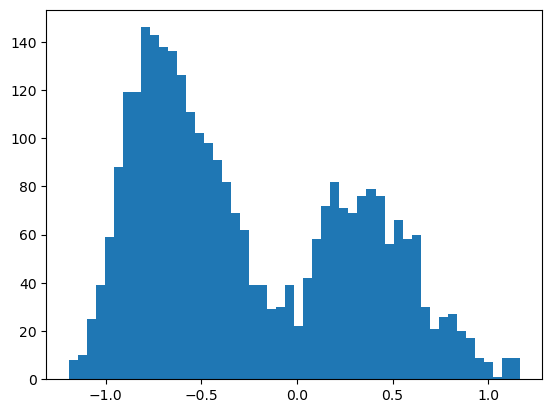

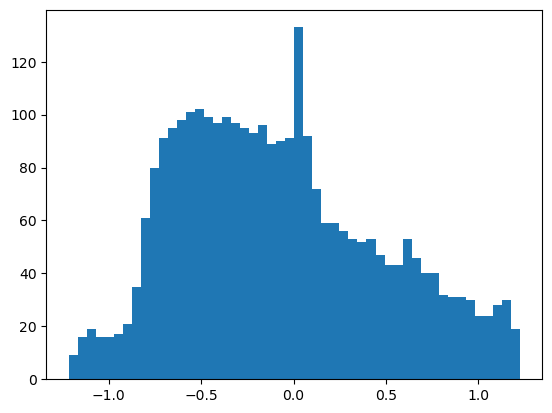

distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


In [20]:
plt.hist(EKE_downstream_0, bins = 50)
plt.show()
plt.hist(EKE_downstream_1, bins = 50)
plt.show()
plt.hist(EKE_downstream_2, bins = 50)
plt.show()
plt.hist(EKE_downstream_3, bins = 50)
plt.show()
plt.hist(EKE_downstream_4, bins = 50)
plt.show()
plt.hist(EKE_downstream_5, bins = 50)
plt.show()
plt.hist(EKE_downstream_6, bins = 50)
plt.show()


In [15]:
EKEadv1lag = np.mean(dist[0,7:27])
EKEadv2lag = np.mean(dist[1,7:27])

EKEgenlag = np.mean(dist[2,7:27])
FSlag = np.mean(dist[3,7:27])
RSlag = np.mean(dist[4,7:27])
MPlag = np.mean(dist[6,7:27])
print(EKEadv1lag)
print(EKEadv2lag)

print(EKEgenlag)
print(FSlag)
print(RSlag)
print(MPlag)

-0.29770853698730465
-0.08666010095214843
-0.08775490107421874
-0.33806248229980473
-0.1076751861328125
-0.0467045705810547
